# PERSIANN-CDR precipitation

## 1 Overview

- **In this notebook you will find:**
    - PERSIANN-CDR precipitation data analysis for South America.
    - Spatial and temporal resolutions are 0.25 x 0.25 (original) and monthly (cumulative), respectively.
    - Monthly means for the period from 1983 to 2019.
    - Time series for some locations of statistical significant trends.
    - Calculate trends for Standardized Precipitation Index (SPI) for the whole period.
    - Droughts of 2005 and 2010 (and 2019).
    - See [this climate data guide page](https://climatedataguide.ucar.edu/climate-data/standardized-precipitation-index-spi) on Standardized Precipitation Index.

## 2 Initial setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Load packages.
import sys
import glob
import warnings
import scipy

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
import cartopy.crs as ccrs

from dask.diagnostics import ProgressBar

warnings.filterwarnings("ignore")
xr.set_options(display_style="text")
%matplotlib inline

In [22]:
# My package.
repos = "/home/alex/Dropbox/repositories/cdlearn/"
if repos not in sys.path:
    sys.path.append(repos)

# Work in progress.    
from cdlearn.utils import organize_data
from cdlearn.maps import south_america, south_america_months
from cdlearn.statistics import standard_index_monthly, linear_regression

In [4]:
# Map borders for South America.
loni, lonf, lati, latf = -90, -30, -60, 20

# Period of interest.
ti, tf = "1983-01-01", "2019-12-01"

# Where figures will be put.
fig_path = "/home/alex/Dropbox/repositories/phd/images/"

In [5]:
# Main directory.
DATA_FOLDER = "/media/alex/ALEXDATA/data_sets/PERSIANN_CDR/MSUM/"

## 3 Load data

In [8]:
%%time

# Original spatial resolution data files.
FILES = sorted(glob.glob(DATA_FOLDER + "/*nc"))

# Lazy load.
DS = xr.open_mfdataset(FILES, concat_dim="time", combine="nested")

# South America in the selected period.
DS = DS.sel(
    time=slice(np.datetime64(ti), np.datetime64(tf)), 
    lat=slice(lati, latf), 
    lon=slice(loni, lonf)
)

# My ninja way.
DS = organize_data(DS)

# Show it.
print(DS)

<xarray.Dataset>
Dimensions:        (lat: 320, lon: 240, time: 444)
Coordinates:
  * lat            (lat) float32 -59.875 -59.625 -59.375 ... 19.625 19.875
  * lon            (lon) float32 -89.875 -89.625 -89.375 ... -30.375 -30.125
  * time           (time) datetime64[ns] 1983-01-01 1983-02-01 ... 2019-12-01
Data variables:
    precipitation  (time, lat, lon) float32 dask.array<chunksize=(12, 320, 240), meta=np.ndarray>
Attributes:
    datetime:                   1983-01-01
    Conventions:                CF-1.6
    title:                      NOAA Climate Data Record (CDR) of Precipitati...
    comment:                    Daily PERSIANN-CDR precipitation estimates fo...
    source:                     GRIDSAT-B1.1983.01.01.00.v02r01.nc,GRIDSAT-B1...
    Metadata_Conventions:       CF-1.6,Unidata Dataset Discovery v1.0, NOAA C...
    standard_name_vocabulary:   CF Standard Name Table (v26, 08 November 2013)
    id:                         PERSIANN-CDR_v01r01_19830101_c20140523.nc
    

In [11]:
# Into memory.
with ProgressBar():
    DS = DS.load()

[########################################] | 100% Completed | 14.8s


## 4 Monthly means

In [12]:
%%time

# Monthly means.
DA_mm = DS.precipitation.groupby("time.month").mean("time")

CPU times: user 137 ms, sys: 30.8 ms, total: 168 ms
Wall time: 442 ms


CPU times: user 6.28 s, sys: 68.5 ms, total: 6.35 s
Wall time: 6.36 s


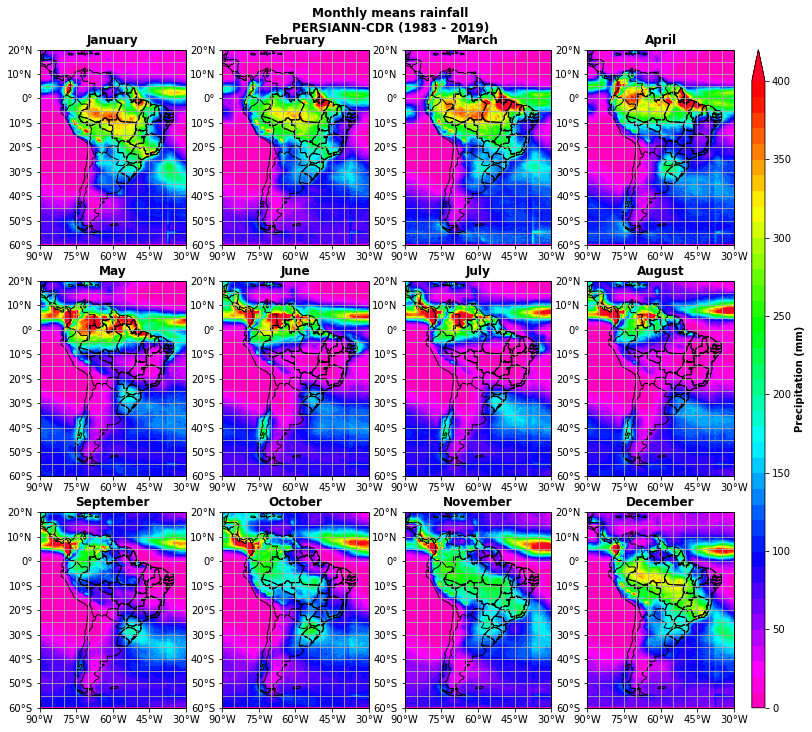

In [20]:
%%time

# Grid of maps.
axgr = south_america_months(title="Monthly means rainfall\nPERSIANN-CDR (1983 - 2019)")

# Plot data on these maps.
for index, axis in enumerate(axgr):

    # Data limits.
    vmin = 0; vmax = 400; dv = 20
    
    plotmap = DA_mm.isel(month=index).plot(
        ax=axis,
        vmin=vmin,
        vmax=vmax,
        levels=np.arange(vmin, vmax + dv/2, dv/2),
        cmap=plt.cm.gist_rainbow_r,
        add_colorbar=False,
        add_labels=False
    )
    
# Fill common colorbar.   
cb = plt.colorbar(plotmap, cax=axgr.cbar_axes[0], orientation="vertical")    
cb.set_label("Precipitation (mm)", weight="bold")

# Save figures.
plt.savefig(
    fig_path + "precipitation_persiann_cdr_cum_mmeans.jpg", 
    dpi=200, 
    bbox_inches="tight"
)

## 5 Long term trends

In [23]:
# Slope, intercept, r value, p value, and stdandard error for linear regression.
linstats = linear_regression(DS.precipitation, verbose=True)

>>> Loop over grid points ...


 99% (76605 of 76800) |################# | Elapsed Time: 0:00:25 ETA:   0:00:00

CPU times: user 12.8 s, sys: 237 ms, total: 13.1 s
Wall time: 12.8 s


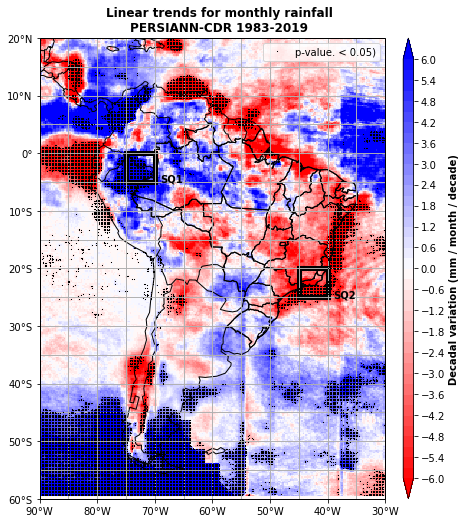

In [34]:
%%time

# Grid of maps.
axgr = south_america(
    suptitle="Linear trends for monthly rainfall\nPERSIANN-CDR 1983-2019"
)

# Data limits.
scale = 120
vmin = -0.05; vmax = 0.05; dv = 0.005; 

# Plot data on that maps. 
plotmap = (linstats.sel(stats="slope") * scale).plot(
    ax=axgr[0],
    vmin=vmin * scale,
    vmax=vmax * scale,
    levels=np.arange(vmin, vmax + dv/2, dv/2) * scale,
    cmap=plt.cm.bwr_r,
    add_colorbar=False,
    add_labels=False
)
    
# Box for region 1.
axgr[0].text(x=-69, y=-5, s="SQ1", color="black", weight="bold")
axgr[0].add_patch(mpatches.Rectangle(
            xy=[-75, -5], 
            width=5, 
            height=5,
            fill=None,
            lw=5,
            edgecolor="black",
            facecolor="black"
))
        
# Box for region 2.
axgr[0].text(x=-39, y=-25, s="SQ2", color="black", weight="bold")
axgr[0].add_patch(mpatches.Rectangle(
            xy=[-45, -25], 
            width=5, 
            height=5,
            fill=None,
            lw=5,
            edgecolor="black",
            facecolor="black"
))

# Fill common colorbar.   
cb = plt.colorbar(plotmap, cax=axgr.cbar_axes[0], orientation="vertical")    
cb.set_label("Decadal variation (mm / month / decade)", weight="bold")
cb.set_ticks(np.arange(vmin, vmax + dv, dv) * scale)

# Statistical significant trends.
mask = linstats.sel(stats="p_value") < 0.05
mask_up = linstats.sel(stats="slope") > 0
mask_down = linstats.sel(stats="slope") < 0
LON, LAT = np.meshgrid(mask.lon.values, mask.lat.values)

# Incresing!
msk = np.logical_and(mask, mask_up)
axgr[0].plot(
    LON[msk], LAT[msk], "xk", ms=0.5, label="p-value. < 0.05)", 
    transform=ccrs.PlateCarree()
)
    
# Decreasing!
msk = np.logical_and(mask, mask_down)
axgr[0].plot(
    LON[msk], LAT[msk], "xk", ms=0.5, 
    transform=ccrs.PlateCarree()
)    

# Legend and adjustment.     
axgr[0].legend() 
plt.subplots_adjust(top=0.925)

# Save figures.
plt.savefig(
    fig_path + "precipitation_persiann_cdr_trends.jpg", 
    dpi=200, 
    bbox_inches="tight"
)

## 6 Time series

CPU times: user 9.4 s, sys: 25.2 ms, total: 9.43 s
Wall time: 9.52 s


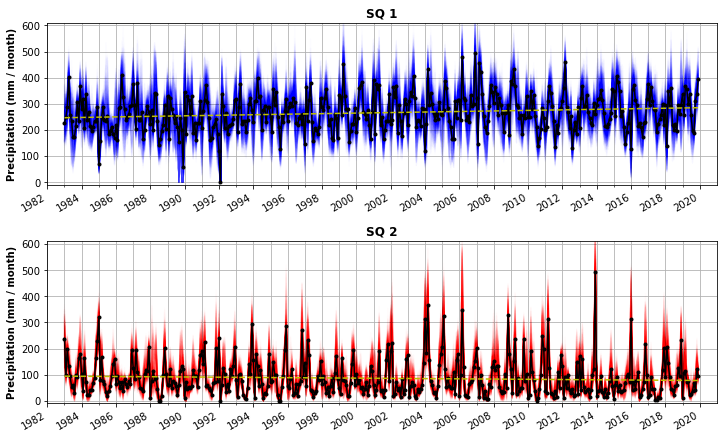

In [35]:
%%time

# Create a figure.
fig, axis = plt.subplots(2, 1, figsize=(12, 7))

# Format for x axis markers.
years = mdates.YearLocator(2)
years_fmt = mdates.DateFormatter("%Y")

# Region 1.
TSs = DS.precipitation.sel(lon=slice(-75, -70), lat=slice(-5, 0))

# Show all time series.
for lon_gp in TSs.lon:      # Grid point longiudes,
    for lat_gp in TSs.lat:  # and latitudes.
        
        # Plot.
        TSs.sel(lon=lon_gp, lat=lat_gp).plot(
            ax=axis[0],
            color="blue",
            alpha=0.01
        )  
# Plot median time series.
TSs.median(dim=["lat", "lon"]).plot(
    ax=axis[0],
    color="black",
    marker=".",
    label="Mean"
)    
 
# Linear regression.
DATES = TSs.time.values
X = np.arange(DATES.shape[0])
Y = TSs.median(dim=["lat", "lon"]).values
masknan = np.isnan(Y)
X = X[~masknan]
Y = Y[~masknan]
DATES = DATES[~masknan]
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(X, Y)    

# Plot linear regression.
Yhat = X * slope + intercept
axis[0].plot(DATES, Yhat, "--y")

# Region 2.
TSs = DS.precipitation.sel(lon=slice(-40, -35), lat=slice(-25, -20))

# Show all time series.
for lon_gp in TSs.lon:      # Grid point longiudes,
    for lat_gp in TSs.lat:  # and latitudes.
        
        # Plot.
        TSs.sel(lon=lon_gp, lat=lat_gp).plot(
            ax=axis[1],
            color="red",
            alpha=0.01
        )  
        
# Plot median time series.
TSs.median(dim=["lat", "lon"]).plot(
    ax=axis[1],
    color="black",
    marker=".",
    label="Mean"
)      
       
# Linear regression.
DATES = TSs.time.values
X = np.arange(DATES.shape[0])
Y = TSs.median(dim=["lat", "lon"]).values
masknan = np.isnan(Y)
X = X[~masknan]
Y = Y[~masknan]
DATES = DATES[~masknan]
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(X, Y)    

# Plot linear regression.
Yhat = X * slope + intercept
axis[1].plot(DATES, Yhat, "--y")    
    
# Adjustments to plots.
plt.subplots_adjust(hspace=0.35)
for ax, title in zip(axis, ["SQ 1", "SQ 2"]):
    ax.set_ylabel("Precipitation (mm / month)", weight="bold")
    ax.set_xlabel(None)
    ax.set_title(title, weight="bold")
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(years_fmt)
    yi = np.unique(TSs.time.dt.year)[0] - 1
    yf = np.unique(TSs.time.dt.year)[-1]
    ax.set_xlim(pd.Timestamp(str(yi)), pd.Timestamp(str(yf + 2)))
    ax.set_xticks(pd.date_range(start=str(yi), end=str(yf), freq="1YS"), minor=True)
    ax.grid(which="both")
    _ = ax.set_ylim((-10, 610))    
    
# Save figures.
plt.savefig(
    fig_path + "precipitation_persiann_cdr_time_series.jpg", 
    dpi=200, 
    bbox_inches="tight"
)  

## 7 Standardized Precipitation Index

### 7.1 Long term trends

In [37]:
%%time

DAspi = standard_index_monthly(DS.precipitation, robust=False)

CPU times: user 1.28 s, sys: 152 ms, total: 1.43 s
Wall time: 1.6 s


In [38]:
# Slope, intercept, r value, p value, and stdandard error for linear regression.
linstats = linear_regression(DAspi, verbose=True)

>>> Loop over grid points ...


 99% (76695 of 76800) |################# | Elapsed Time: 0:00:27 ETA:   0:00:00

Text(0.5, 1.0, 'Precipitation data')

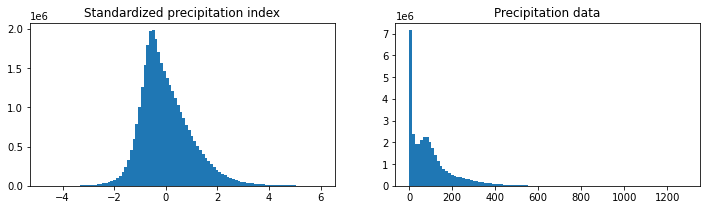

In [39]:
# Sanity check. Compare all distributions.
_, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 3))
axes.flatten()[0].hist(DAspi.values.flatten(), bins=100)
axes.flatten()[0].set_title("Standardized precipitation index")
axes.flatten()[1].hist(DS.precipitation.values.flatten(), bins=100)
axes.flatten()[1].set_title("Precipitation data")

>>>KS TEST: Ks_2sampResult(statistic=0.02702702702702703, pvalue=1.0)


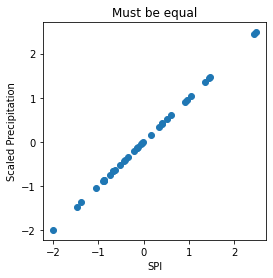

In [40]:
# Sanity check. Must be equal
D1 = DAspi.sel(lat=-3, lon=-60, method="nearest").\
           sel(time=DS.time[DS.time.dt.month==8]).\
           values.flatten()
D2 = DS.precipitation.sel(lat=-3, lon=-60, method="nearest").\
                      sel(time=DS.time[DS.time.dt.month==8]).\
                      values.flatten()
D2_scaled = (D2 - np.mean(D2)) / np.std(D2)
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))
plt.scatter(D1, D2_scaled)
plt.xlabel("SPI"); plt.ylabel("Scaled Precipitation"); plt.title("Must be equal")
print(">>>KS TEST:", scipy.stats.ks_2samp(D1, D2_scaled))

CPU times: user 13.1 s, sys: 153 ms, total: 13.3 s
Wall time: 13.2 s


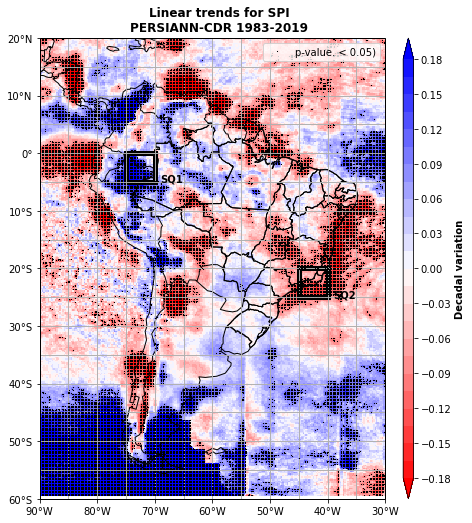

In [41]:
%%time

# Grid of maps.
axgr = south_america(
    suptitle="Linear trends for SPI\nPERSIANN-CDR 1983-2019"
)

# Data limits.
scale = 120
vmin = -1.5e-3; vmax = 1.5e-3; dv = 2.5e-4; 

# Plot data on that maps. 
plotmap = (linstats.sel(stats="slope") * scale).plot(
    ax=axgr[0],
    vmin=vmin * scale,
    vmax=vmax * scale,
    levels=np.arange(vmin, vmax + dv/2, dv/2) * scale,
    cmap=plt.cm.bwr_r,
    add_colorbar=False,
    add_labels=False
)
    
# Box for region 1.
axgr[0].text(x=-69, y=-5, s="SQ1", color="black", weight="bold")
axgr[0].add_patch(mpatches.Rectangle(
            xy=[-75, -5], 
            width=5, 
            height=5,
            fill=None,
            lw=5,
            edgecolor="black",
            facecolor="black"
))
        
# Box for region 2.
axgr[0].text(x=-39, y=-25, s="SQ2", color="black", weight="bold")
axgr[0].add_patch(mpatches.Rectangle(
            xy=[-45, -25], 
            width=5, 
            height=5,
            fill=None,
            lw=5,
            edgecolor="black",
            facecolor="black"
))

# Fill common colorbar.   
cb = plt.colorbar(plotmap, cax=axgr.cbar_axes[0], orientation="vertical")    
cb.set_label("Decadal variation", weight="bold")
cb.set_ticks(np.arange(vmin, vmax + dv, dv) * scale)

# Statistical significant trends.
mask = linstats.sel(stats="p_value") < 0.05
mask_up = linstats.sel(stats="slope") > 0
mask_down = linstats.sel(stats="slope") < 0
LON, LAT = np.meshgrid(mask.lon.values, mask.lat.values)

# Incresing!
msk = np.logical_and(mask, mask_up)
axgr[0].plot(
    LON[msk], LAT[msk], "xk", ms=0.5, label="p-value. < 0.05)", 
    transform=ccrs.PlateCarree()
)
    
# Decreasing!
msk = np.logical_and(mask, mask_down)
axgr[0].plot(
    LON[msk], LAT[msk], "xk", ms=0.5, 
    transform=ccrs.PlateCarree()
)    

# Legend and adjustment.     
axgr[0].legend() 
plt.subplots_adjust(top=0.925)

# Save figures.
plt.savefig(
    fig_path + "spi_persiann_cdr_trends.jpg", 
    dpi=200, 
    bbox_inches="tight"
)

### 7.2 Time series

CPU times: user 9.85 s, sys: 58.6 ms, total: 9.91 s
Wall time: 9.89 s


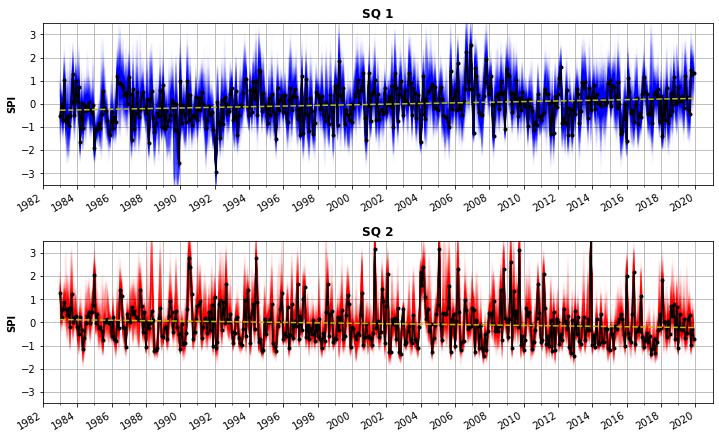

In [42]:
%%time

# Create a figure.
fig, axis = plt.subplots(2, 1, figsize=(12, 7))

# Format for x axis markers.
years = mdates.YearLocator(2)
years_fmt = mdates.DateFormatter("%Y")

# Region 1.
TSs = DAspi.sel(lon=slice(-75, -70), lat=slice(-5, 0))

# Show all time series.
for lon_gp in TSs.lon:      # Grid point longiudes,
    for lat_gp in TSs.lat:  # and latitudes.
        
        # Plot.
        TSs.sel(lon=lon_gp, lat=lat_gp).plot(
            ax=axis[0],
            color="blue",
            alpha=0.01
        )  
# Plot median time series.
TSs.median(dim=["lat", "lon"]).plot(
    ax=axis[0],
    color="black",
    marker=".",
    label="Mean"
)    
 
# Linear regression.
DATES = TSs.time.values
X = np.arange(DATES.shape[0])
Y = TSs.median(dim=["lat", "lon"]).values
masknan = np.isnan(Y)
X = X[~masknan]
Y = Y[~masknan]
DATES = DATES[~masknan]
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(X, Y)    

# Plot linear regression.
Yhat = X * slope + intercept
axis[0].plot(DATES, Yhat, "--y")

# Region 2.
TSs = DAspi.sel(lon=slice(-40, -35), lat=slice(-25, -20))

# Show all time series.
for lon_gp in TSs.lon:      # Grid point longiudes,
    for lat_gp in TSs.lat:  # and latitudes.
        
        # Plot.
        TSs.sel(lon=lon_gp, lat=lat_gp).plot(
            ax=axis[1],
            color="red",
            alpha=0.01
        )  
        
# Plot median time series.
TSs.median(dim=["lat", "lon"]).plot(
    ax=axis[1],
    color="black",
    marker=".",
    label="Mean"
)      
       
# Linear regression.
DATES = TSs.time.values
X = np.arange(DATES.shape[0])
Y = TSs.median(dim=["lat", "lon"]).values
masknan = np.isnan(Y)
X = X[~masknan]
Y = Y[~masknan]
DATES = DATES[~masknan]
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(X, Y)    

# Plot linear regression.
Yhat = X * slope + intercept
axis[1].plot(DATES, Yhat, "--y")    
    
# Adjustments to plots.
plt.subplots_adjust(hspace=0.35)
for ax, title in zip(axis, ["SQ 1", "SQ 2"]):
    ax.set_ylabel("SPI", weight="bold")
    ax.set_xlabel(None)
    ax.set_title(title, weight="bold")
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(years_fmt)
    yi = np.unique(TSs.time.dt.year)[0] - 1
    yf = np.unique(TSs.time.dt.year)[-1]
    ax.set_xlim(pd.Timestamp(str(yi)), pd.Timestamp(str(yf + 2)))
    ax.set_xticks(pd.date_range(start=str(yi), end=str(yf), freq="1YS"), minor=True)
    ax.grid(which="both")
    _ = ax.set_ylim((-3.5, 3.5))    
    
# Save figures.
plt.savefig(
    fig_path + "spi_persiann_cdr_time_series.jpg", 
    dpi=200, 
    bbox_inches="tight"
)  

### 7.3 Droughts of 2005 and 2010 (and 2019)

CPU times: user 6.14 s, sys: 47.3 ms, total: 6.19 s
Wall time: 6.18 s


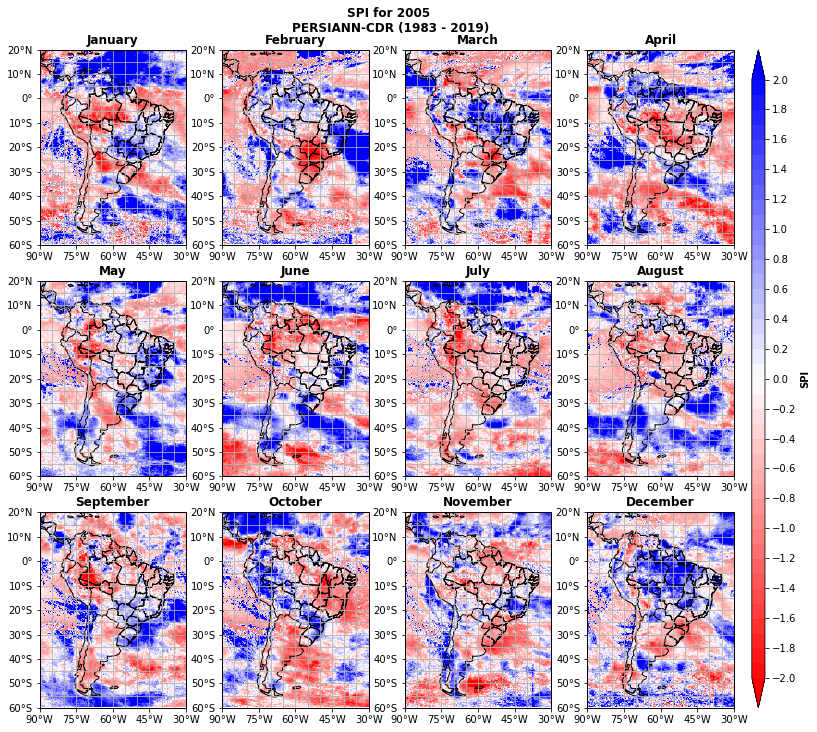

In [52]:
%%time

# Grid of maps.
axgr = south_america_months(title="SPI for 2005 \nPERSIANN-CDR (1983 - 2019)")

# Plot data on these maps.
for index, axis in enumerate(axgr):

    mask_month = DAspi.time.dt.month == index + 1
    mask_year = DAspi.time.dt.year == 2005
    mask_drought = mask_month & mask_year
    
    # Data limits.
    vmin = -2; vmax = 2; dv = 0.2
    
    plotmap = DAspi[mask_drought].plot(
        ax=axis,
        vmin=vmin,
        vmax=vmax,
        levels=np.arange(vmin, vmax + dv/2, dv/2),
        cmap=plt.cm.bwr_r,
        add_colorbar=False,
        add_labels=False
    )

# Fill common colorbar.   
cb = plt.colorbar(plotmap, cax=axgr.cbar_axes[0], orientation="vertical")    
cb.set_label("SPI", weight="bold")
cb.set_ticks(np.arange(vmin, vmax + dv, dv))    
    
# Save figures.
plt.savefig(
    fig_path + "spi_persiann_cdr_2005.jpg", 
    dpi=200, 
    bbox_inches="tight"
)

CPU times: user 6.61 s, sys: 75.7 ms, total: 6.69 s
Wall time: 6.69 s


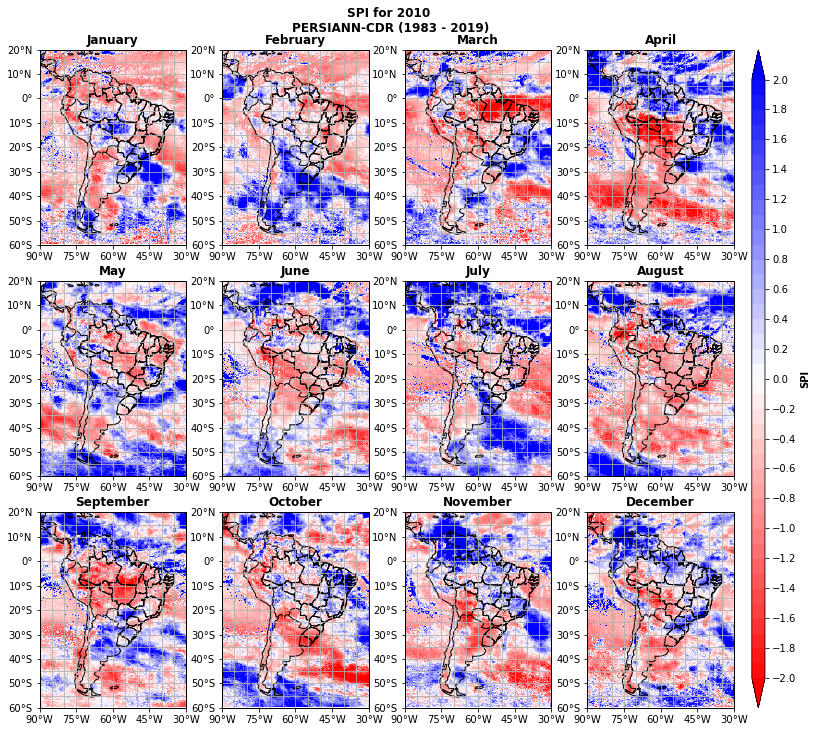

In [53]:
%%time

# Grid of maps.
axgr = south_america_months(title="SPI for 2010 \nPERSIANN-CDR (1983 - 2019)")

# Plot data on these maps.
for index, axis in enumerate(axgr):

    mask_month = DAspi.time.dt.month == index + 1
    mask_year = DAspi.time.dt.year == 2010
    mask_drought = mask_month & mask_year
    
    # Data limits.
    vmin = -2; vmax = 2; dv = 0.2
    
    plotmap = DAspi[mask_drought].plot(
        ax=axis,
        vmin=vmin,
        vmax=vmax,
        levels=np.arange(vmin, vmax + dv/2, dv/2),
        cmap=plt.cm.bwr_r,
        add_colorbar=False,
        add_labels=False
    )

# Fill common colorbar.   
cb = plt.colorbar(plotmap, cax=axgr.cbar_axes[0], orientation="vertical")    
cb.set_label("SPI", weight="bold")
cb.set_ticks(np.arange(vmin, vmax + dv, dv))    
    
# Save figures.
plt.savefig(
    fig_path + "spi_persiann_cdr_2010.jpg", 
    dpi=200, 
    bbox_inches="tight"
)

CPU times: user 6.73 s, sys: 47.7 ms, total: 6.77 s
Wall time: 6.78 s


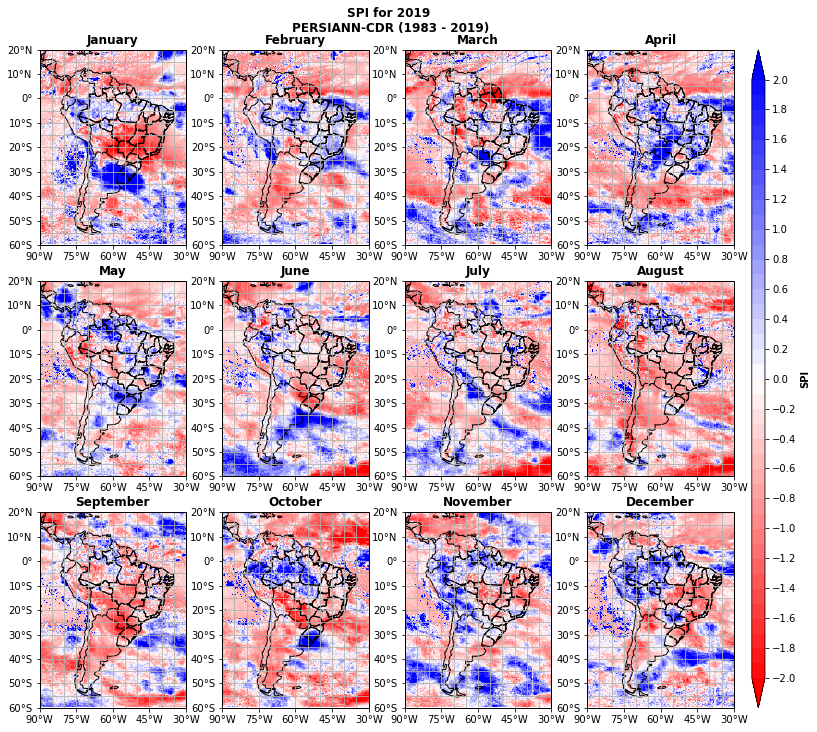

In [55]:
%%time

# Grid of maps.
axgr = south_america_months(title="SPI for 2019 \nPERSIANN-CDR (1983 - 2019)")

# Plot data on these maps.
for index, axis in enumerate(axgr):

    mask_month = DAspi.time.dt.month == index + 1
    mask_year = DAspi.time.dt.year == 2019
    mask_drought = mask_month & mask_year
    
    # Data limits.
    vmin = -2; vmax = 2; dv = 0.2
    
    plotmap = DAspi[mask_drought].plot(
        ax=axis,
        vmin=vmin,
        vmax=vmax,
        levels=np.arange(vmin, vmax + dv/2, dv/2),
        cmap=plt.cm.bwr_r,
        add_colorbar=False,
        add_labels=False
    )

# Fill common colorbar.   
cb = plt.colorbar(plotmap, cax=axgr.cbar_axes[0], orientation="vertical")    
cb.set_label("SPI", weight="bold")
cb.set_ticks(np.arange(vmin, vmax + dv, dv))    
    
# Save figures.
plt.savefig(
    fig_path + "spi_persiann_cdr_2019.jpg", 
    dpi=200, 
    bbox_inches="tight"
)